In [1]:
pip install scikit-lego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.7/217.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.1/195.1 kB 11.4 MB/s eta 0:00:00


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.base import clone
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, recall_score, roc_auc_score, roc_curve, r2_score,f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Applying Cleaning Function

1. We're choosing 'explicit' as our binary categorical response variable.

In [5]:
# Data Cleaning Function
def clean_data(df):
  clean_df = df.copy()
  clean_df = clean_df.drop('Unnamed: 0', axis=1, errors='ignore')
  clean_df = clean_df.dropna()

  #Encode explicit column (binary encoding)
  clean_df['explicit'] = clean_df['explicit'].astype(int)

  #Remove track_id, artists,album_name, track_name
  clean_df = clean_df.drop(['track_id', 'artists', 'album_name', 'track_name','track_genre'], axis=1)

  return clean_df

# Apply the function to the DataFrame
spotify_clean = clean_data(df)

In [6]:
spotify_clean.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


In [7]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(spotify_clean.drop('explicit', axis=1), spotify_clean['explicit'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91199, 14), (22800, 14), (91199,), (22800,))

In [8]:
y_train.head()

,explicit
96253,0
70417,0
66688,0
51391,0
95123,0


In [9]:
#Class imbalance in y_train
y_train.value_counts()

,count
explicit,
0,83348
1,7851


In [10]:
7851/(7851+83348)*100 #Really small percentage of explicit (True)

8.60864702463843

## Stage 5: KNN or Random Forest Algorithm
1. For the data set you have chosen and the binary categorical response variable that you had chosen for Check-In 3 for a logistic regression or another binary variable in your data set, apply the KNN algorithm or Random Forest Algorithm for classification.(The variable chosen does not have to be directly related to the final goal of your project.)

In [35]:
# Train and Fit Model for KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

2. Calculate the confusion matrix, prediction accuracy, prediction error, true positive rate, and true negative rate, and F1 score on your training data set

In [36]:
# Confusion Matrix
y_pred_train = knn.predict(X_train)
cm_knn = confusion_matrix(y_train, y_pred_train)
cm_knn

array([[82699,   649],
       [ 5633,  2218]])

In [37]:
# Prediction Accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Prediction Accuracy:", accuracy)

Prediction Accuracy: 0.931117665763879


In [38]:
# Prediction Error
error = (cm_knn[0,1] + cm_knn[1,0])/cm_knn.sum()
print("Prediction Error:", error)

Prediction Error: 0.06888233423612102


In [39]:
# True Positive Rate
tpr = recall_score(y_train, y_pred_train, pos_label=1)
print("True Positive Rate:", tpr)

True Positive Rate: 0.28251178193860654


In [40]:
# True Negative Rate
tnr = recall_score(y_train, y_pred_train, pos_label=0)
print("True Negative Rate:", tnr)

True Negative Rate: 0.9922133704468014


In [41]:
# F1 Score
f1 = f1_score(y_train, y_pred_train)
print("F1 Score:", f1)

F1 Score: 0.4138831871617839


In [42]:
#Classification Report
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     83348
           1       0.77      0.28      0.41      7851

    accuracy                           0.93     91199
   macro avg       0.85      0.64      0.69     91199
weighted avg       0.92      0.93      0.92     91199



3. Calculate and plot the ROC curve and AUC on your validation data set. Use 5-fold cross-validation on the validation set to calculate the AUC and accuracy of each fold.

In [51]:
# Calculating the ROC curve and the AUC score
y_pred_proba = knn.predict_proba(X_test)[:, 1]
y_pred = knn.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

AUC Score: 0.6901616173635231


Text(0.5, 1.0, 'Receiver Operating Characteristic')

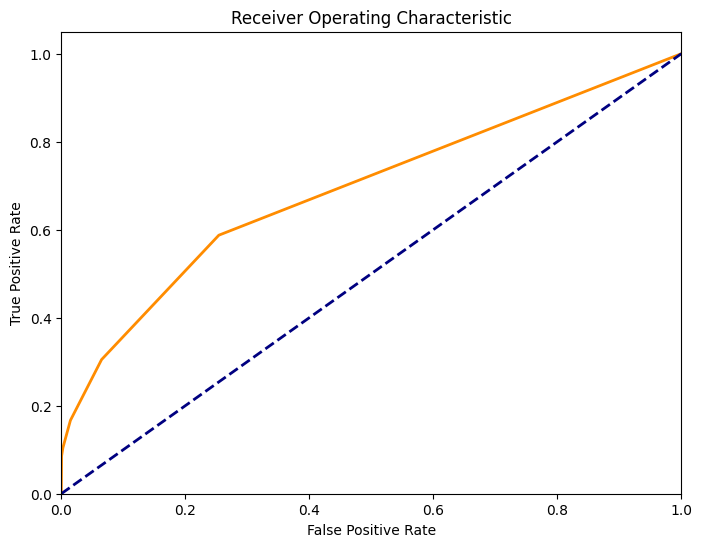

In [49]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

In [50]:
# Using 5-fold cross-validation on the validation set (calculate the AUC and accuracy of each fold)
X = X_test
y = y_test
cross_val_score(knn, X, y, cv=5, scoring='roc_auc')

skfolds = StratifiedKFold(n_splits=5)
i = 1
for train_index, test_index in skfolds.split(X, y):
    clone_lr = clone(knn)
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    print(test_index)
    clone_lr.fit(X_train_folds, y_train_folds)
    y_pred = clone_lr.predict(X_test_fold)

    auc_sample = roc_auc_score(y_true=y.iloc[test_index], y_score=y_pred)
    print("Fold: ", i, "\nAUC: ", auc_sample, '\nAccuracy: ', accuracy_score(y_true=y.iloc[test_index], y_pred=y_pred))
    i += 1


[   0    1    2 ... 4619 4632 4641]
Fold:  1 
AUC:  0.5200432412238049 
Accuracy:  0.9118421052631579
[4550 4551 4552 ... 9273 9287 9298]
Fold:  2 
AUC:  0.526280781446915 
Accuracy:  0.9122807017543859
[ 9109  9110  9111 ... 13677 13678 13679]
Fold:  3 
AUC:  0.528433376519864 
Accuracy:  0.9162280701754386
[13680 13681 13682 ... 18237 18248 18272]
Fold:  4 
AUC:  0.5241243999270478 
Accuracy:  0.9105263157894737
[18238 18239 18240 ... 22797 22798 22799]
Fold:  5 
AUC:  0.5284688995215311 
Accuracy:  0.9140350877192982
